## Generative MODEL using PIX2PIX + ATTENTION to perform the follwing task

#### 1.  Rotate the protoplanetary disk images from any arbitray orientation to face-on images


@author: Sayantan
date: 22 Jan 2024


This notebook is adopted from the GAN_Image_rotate-V4.py

## To rotate disk images from any arbitary angles to face-on images¶ but with the added attention block
We shall use the DPPNET-Rt synthetic dataset for this purpose

## UPDATE
Compared to the  GAN_Image_rotate-V3.py, we will now use less images to reduce the computation cost
Compared to the  GAN_Image_rotate-V4.py, we will implement Attention based PIX2PIX GAN netwwork and compare the model without Attention 

##### We will call make the code moduler this time



In [7]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import sys
import platform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import csv
import re ## For data manipulation
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps

##############################
#### IMPORT THE PIX2PIX model along with the attention module
###########################
import network as net

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")

# print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")



Python Platform: Linux-3.10.0-1160.88.1.el7.x86_64-x86_64-with-glibc2.30
PyTorch Version: 2.0.1
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda:0


In [8]:
def create_complete_data_csv(list_sorted_RT_path ,path,selection_list=None):
    '''
    Input : list_sorted_RT_path : list of address to the RT image folder, example "RT_A_1"
            Path: to the working directory where the cluster_run_1.csv is and the data_folder is created
            selection_list(OPTIONAL):allows selection of only the rotated images for training otherwise all images are selected
    
    Output : Returns a concatinated csv with path to the RT images and the corresponding target image  
    
    
    '''
    
    dataset_complete = []
    print("[INFO]: Importing path for all the RT images")
    
    if selection_list is not None:
        print("INFO: Considering only the rotated images for input")
    else:
        print("INFO: Considering all images")
    
    for index in range(len(list_sorted_RT_path)):
        path_image = list_sorted_RT_path[index] ## path to each RT folder
        # print(path_image)
        if selection_list is None:
            ## for paths from the RT sim fodlers directly
            list_image_path = glob.glob(path_image +  "/image_"+"*.png") ## list of the path to each image in the RT folder
            list_sorted_image_path  = sorted(list_image_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1])    
        else:
            if not selection_list.empty :             
                list_sorted_image_path = []
                for j in selection_list:  
                    list_image_path = str(path_image +  "/image_"+ str(j)+ ".png")
                    list_sorted_image_path.append(list_image_path)
         

        df_images_folder =pd.DataFrame(list_sorted_image_path,columns=["image_path"]) ## making a dataframe with the images path
        df_images_folder ['target'] = df_images_folder['image_path'].iloc[0]
        df_images_folder = df_images_folder.iloc[1:] ## droping the 1st row since it always has the face on image
            

        # Appending the data from the pandas dataframe for each orbits
        dataset_complete.append(df_images_folder)

    dataset_complete = pd.concat(dataset_complete, ignore_index=True, axis=0)  
    dataset_complete.to_csv(path+data_out_foler+'/dataset_complete.csv') 
    return  dataset_complete

In [9]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=256, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

Namespace(f='/home/sauddy3/.local/share/jupyter/runtime/kernel-cb6bfd55-09e9-4cd3-a60c-fea3d136a38b.json', n_epochs=20, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, n_classes=10, img_size=256, channels=3, sample_interval=100)


In [10]:
## This block allow to use images with both non-zero inclination angle and posang angles
df = pd.read_csv('./RT_Dataset_incl_posang.csv')  #path of csv file
# print("The dataframe is:") #displaying csv
# print(df,"\n")
Ind, X_inlabel, Y_inlabel = [], [], []
Ind = df["index"] #to store the image numbers excluding translational changes
# Ind.values.tolist()


In [11]:
############# Address to the data folder ###################
current_directory = os.getcwd()
data_out_foler = "data_folder_attention"
os.makedirs(data_out_foler, exist_ok=True)
path = current_directory + '/' # For local computer 
# ## updating the image paths once the transfer is done
try:     
    list_RT_path = glob.glob(path+ 'image_directory_complete/'+ 'RT_A_*') ## make a list of all the RT folder where each folder is for each sim
    list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images
    data_complete = create_complete_data_csv(list_sorted_RT_path,path,selection_list=Ind)
except ValueError:
    pass
    print("Looking for images in the folder above-- Please give the correct path to the images if images are not loaded")
    list_RT_path = glob.glob(path+ '../image_directory_complete/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
    # ## For google colab this needs to be updated
    list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images
    data_complete = create_complete_data_csv(list_sorted_RT_path,path,selection_list=Ind)
    
    
complete_dataset_mod = data_complete
## Split the dataset and only consider 100 percent of the data:

### Please select what percetage of the data to be used 
use_percentage = 50  ## in percentage
if use_percentage != 100:
    kept_out = (100 - use_percentage)/100 

    split = train_test_split(complete_dataset_mod, test_size=kept_out, random_state=42)
    dataset, dataset_unused = split
else:
    dataset = complete_dataset_mod


[INFO]: Importing path for all the RT images
INFO: Considering only the rotated images for input


In [12]:
dataset

,image_path,target
2588,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
4695,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
15119,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
14185,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
5241,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
...,...,...
11284,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
11964,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
5390,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
860,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...


In [13]:
## Splitting the data for training and testing 

split_1 = train_test_split(dataset, test_size=0.15, random_state=42)
(train, test) = split_1
train.to_csv(path+data_out_foler+'/train.csv') 
test.to_csv(path+data_out_foler+'/test.csv') 


In [14]:
## Defining a custom class that returns image tensor and the corresponding label for a given index

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe,transform = None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df["image_path"].iloc[index]
        target_filename = self.df["target"].iloc[index]
        image = Image.open(filename)
        target_image = Image.open(target_filename)
        
        if opt.channels ==3:
            image = image.convert('RGB')#('L')# ## Converting to gray-scale with one channel        
            target_image = target_image.convert('RGB')#('L')#
        elif opt.channels ==1:
            image = image.convert('L')# ## Converting to gray-scale with one channel        
            target_image = target_image.convert('L')#
#         print("THE SHAPE OF THE IMAGE",np.shape(image))
        else:
            print("Input channel can be 1 or 3 only")
            
        ## Cropping parameters selected for this dataset using trail and error method
        left = 105
        top = 55
        right = 480
        bottom = 430 
        
        # Cropped image of above dimension" # (It will not change original image)
        image = image.crop((left, top, right, bottom))
        target_image = target_image.crop((left, top, right, bottom))
        if self.transform is not None:
            image = self.transform(image)
            target_image = self.transform(target_image)

        return image,target_image

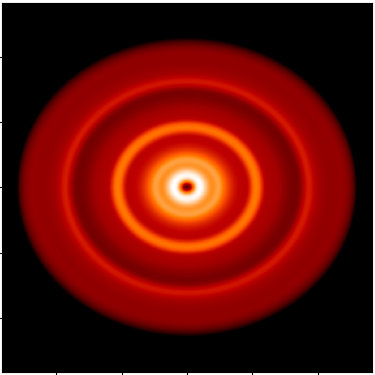

In [15]:
## To verify if the images are read correctly.
image_output = CustomDataset(complete_dataset_mod,transform= None)
# image_output = CustomDataset(train,transform = None)
image ,target_image= image_output.__getitem__(243)
# target_image
image

In [16]:
transform_custom = transforms.Compose([transforms.Resize(opt.img_size),
   transforms.ToTensor()])
image_output = CustomDataset(train,transform= transform_custom)
# image_output = CustomDataset(train,transform = None)
image ,target_image= image_output.__getitem__(10)
print(np.shape(image),np.shape(target_image))
# gray_image = ImageOps.grayscale(image)
# print(type(gray_image))
image.data, target_image.data

save_image(target_image.data, "test.png", normalize=True)


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


In [17]:
# IMG_SIZE = opt.img_size
BATCH_SIZE = opt.batch_size
# Parameters
params = {'batch_size':opt.batch_size ,
          'shuffle': True}


In [18]:
training_set = CustomDataset(train,transform=transform_custom)
training_generator = torch.utils.data.DataLoader(training_set, **params)


In [19]:
# opt.channels, opt.img_size, opt.img_size = 1 ,32,32
img_shape = (opt.channels, opt.img_size, opt.img_size)
print(img_shape)

(3, 256, 256)


In [20]:
# np.prod(img_shape)

In [21]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()


# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, opt.img_size// 2 ** 4, opt.img_size // 2 ** 4)


# Initialize generator and discriminator
# generator = net.GeneratorUNet()
generator = net.GeneratorUNet_attn()
discriminator = net.Discriminator()

generator.to(device)
discriminator.to(device)
criterion_GAN.to(device)
criterion_pixelwise.to(device)


# Initialize weights
generator.apply(net.weights_init_normal)
discriminator.apply(net.weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [22]:
test[100:100+5]

,image_path,target
8326,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
8089,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
14743,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
6172,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...
9385,/project/6000733/sauddy3/GAN_rotation/image_di...,/project/6000733/sauddy3/GAN_rotation/image_di...


In [23]:
from IPython.display import clear_output
def sample_image(batch_size , batches_done=None):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample images
    params_test = {'batch_size':batch_size  ,
          'shuffle': False}
    randomstart = 65 # 55
    test_set = CustomDataset(test[randomstart:randomstart+batch_size],transform=transform_custom)
    test_generator = torch.utils.data.DataLoader(test_set, **params_test )
    print(len(test_set),len(test_generator))
    
    
    
    for i, (imgs,targets) in enumerate(test_generator):
        sample_size = imgs.shape[0]
        print("shape of image",np.shape(imgs))    
        
        input_imgs = Variable(imgs.type(torch.FloatTensor).to(device))   
        print("shape of input image",np.shape(input_imgs))
        
        ## GENERATING THE IMAGES USING THE GENERATOR
        gen_imgs = generator(input_imgs)        
#         print("shape of generated image",np.shape(ge /n_imgs))
  
        
        fig = plt.figure(figsize=(5, 10))
        # fig.text(0.038, 0.5, r"Iteration $\lambda$ = {} ".format(batches_done))
        axes = fig.subplots(batch_size, 3,sharex=False,  sharey=False)
        for i in range(batch_size):
            
            ## Selecting a sample to plot the images as we traing the generator 
            gen_img     =  Variable(gen_imgs[i].type(torch.FloatTensor).to("cpu"), requires_grad=False)
            input_img   =  Variable(input_imgs[i].type(torch.FloatTensor).to("cpu"), requires_grad=False)
            targets_img =  Variable(targets[i].type(torch.FloatTensor).to("cpu"), requires_grad=False)

            g_img = gen_img.permute(1, 2, 0).numpy()
            i_img = input_img.permute(1, 2, 0).numpy()
            t_img = targets_img .permute(1, 2, 0).numpy()
            axes[i][0].imshow(i_img)
            axes[i][1].imshow(g_img)
            axes[i][2].imshow(t_img)
            axes[0][0].set_title("Input")
            axes[0][1].set_title("Gen Sample: {}".format(batches_done))
            axes[0][2].set_title("Target")
            axes[i][0].set_axis_off()
            axes[i][1].set_axis_off()
            axes[i][2].set_axis_off()
            
            clear_output() ## to remove the warning sign 
       
        
        # fig_D = "images/input_test.png"
        plt.savefig("attention_images/input_target%d.png" % batches_done,format='jpg',dpi=300)
        

        
        
        ####### Saving the images using torch save image library #########################

        # cat_images = torch.cat((targets.to(device),gen_imgs.to(device),imgs.type(torch.FloatTensor).to(device)),axis=0)
        # # save_image(gen_imgs.data, "images/%d.png" % batches_done,nrow=batch_size ,normalize=True)
        # save_image(cat_images.data, "images/input_target%d.png" % batches_done,nrow=batch_size ,normalize=True)
    

        

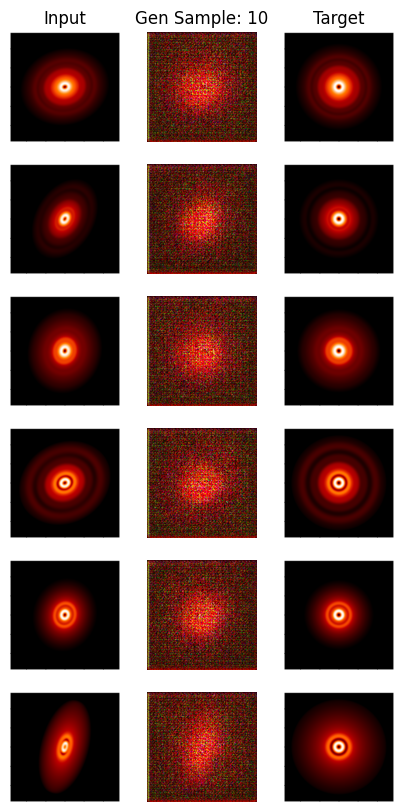

In [24]:
os.makedirs("attention_images", exist_ok=True)
sample_image(batch_size=6,batches_done=10)


In [ ]:
for epoch in range(opt.n_epochs):
    # Training
    for i, (imgs,target_image) in enumerate(training_generator):
        print(type(imgs))
        batch_size = imgs.shape[0]
  
    
        # INPUT INCLIDED IMAGE
        input_imgs = Variable(imgs.type(torch.FloatTensor).to(device))
        
        # TARGET IMAGE
        face_on_image = Variable(target_image.type(torch.FloatTensor).to(device))
        
#         # Adversarial ground truths
#         valid = Variable(torch.FloatTensor(input_imgs.size(0), *patch).fill_(1.0).to(device), requires_grad=False)
#         fake  = Variable(torch.FloatTensor(face_on_image.size(0), *patch).fill_(0.0).to(device), requires_grad=False)
        
        
        
        
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

                
        ######  # GAN loss ##############
        
        # Generate a batch of images
        gen_imgs = generator(input_imgs)
        pred_fake = discriminator(gen_imgs, input_imgs)
        
        # Adversarial ground truths  update to consider any patch    
        valid = torch.ones_like(pred_fake)
        fake  = torch.zeros_like(pred_fake)

        
        loss_GAN = criterion_GAN(pred_fake, valid)
        
#         print(np.shape(gen_imgs),np.shape(face_on_image))
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(gen_imgs, face_on_image)
        
        

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()
        
        
        # Real loss
        pred_real = discriminator(face_on_image, input_imgs)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(gen_imgs.detach(), input_imgs)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------
       

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(training_generator), loss_D.item(), loss_G.item())
        )


        batches_done = epoch * len(training_generator) + i
        # print(batches_done,epoch)
#         print(epoch,batches_done,len(training_generator))
#         print(np.shape(gen_imgs.data))
        if batches_done % opt.sample_interval == 0:
#             save_image(gen_imgs.data[:2], "images/%d.png" % batches_done, nrow=3, normalize=True)
            sample_image(batch_size=6, batches_done=batches_done)


<class 'torch.Tensor'>
[Epoch 18/20] [Batch 71/135] [D loss: 1.746252] [G loss: 2.366243]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 72/135] [D loss: 1.361471] [G loss: 1.727147]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 73/135] [D loss: 1.438005] [G loss: 1.861776]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 74/135] [D loss: 1.280666] [G loss: 1.673566]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 75/135] [D loss: 1.226301] [G loss: 1.547648]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 76/135] [D loss: 1.065039] [G loss: 1.449188]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 77/135] [D loss: 0.946437] [G loss: 1.347163]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 78/135] [D loss: 0.871796] [G loss: 1.330611]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 79/135] [D loss: 0.826600] [G loss: 1.438700]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 80/135] [D loss: 0.842380] [G loss: 1.687295]
<class 'torch.Tensor'>
[Epoch 18/20] [Batch 81/135] [D loss: 0.748646] [G loss: 1.593494]
<class 'to

In [ ]:
# image_output = CustomDataset(test,transform= transform_custom)
# # image_output = CustomDataset(train,transform = None)
# test_image10,_= image_output.__getitem__(16)
# test_image11,_= image_output.__getitem__(3)

# print(np.shape(test_image10),np.shape(test_image11))
# test_cat=torch.cat((test_image10,test_image10),axis=0)
# print(np.shape(test_cat))
# # test

In [ ]:
# input_imgs = Variable(test_cat.type(torch.FloatTensor).to(device)).reshape(2,int(np.prod(img_shape)))
# print(np.shape(input_imgs))
# gen_imgs = generator(input_imgs)

In [ ]:
# gen_imgs = generator(input_imgs)
# print(type(gen_imgs),type(test_cat))
# # print(np.shape(gen_imgs),np.shape(test_cat),np.shape(test_cat.reshape(2,1,256,256)))
# save_image(test_image10.data, "images/in10.png", normalize=True)
# save_image(test_image11.data, "images/in11.png", normalize=True)

# save_image(gen_imgs.data, "images/test1.png", normalize=True)



In [ ]:
# Saving model
model_scripted = torch.jit.script(generator) # Export to TorchScript
model_scripted.save('model_scripted_attention.pt') # Save